# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# Read Data as Numpy Array

In [2]:
# load train and test data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


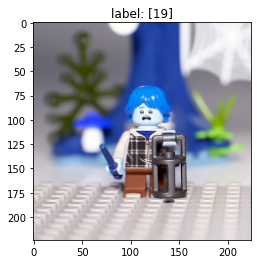

In [3]:
# plot example image
plt.imshow(training_data[0][0])
plt.title("label: {}".format(training_data[0][1]));

In [4]:
X_train = np.array([i[0] for i in training_data])
y_train = np.array([i[1][0] for i in training_data])
X_valid = np.array([i[0] for i in validation_data])
y_valid = np.array([i[1][0] for i in validation_data])

In [5]:
X_train.shape

(170, 224, 224, 3)

# Prepare Data for Training

In [66]:
# augment and normalize data

# create data generator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=10)
valid_datagen = ImageDataGenerator(rescale=1./255)

# create an iterator for the datasets.
# the iterator will return one batch of augmented images for each iteration
epochs = 100
batch_size = 20
IMG_SIZE = 224
total_train = X_train.shape[0]
total_valid = X_valid.shape[0]

iter_train = train_datagen.flow(X_train, y_train, batch_size=batch_size,
                                shuffle=True)
iter_valid = train_datagen.flow(X_valid, y_valid, batch_size=batch_size)

# Visualize some Images

In [67]:
sample_training_images, sample_training_labels = next(iter_train)

In [68]:
print("Shape of a sample batch of images: {}".format(sample_training_images.shape))
print("Shape of a sample lables: {}".format(sample_training_labels.shape))

Shape of a sample batch of images: (20, 224, 224, 3)
Shape of a sample lables: (20,)


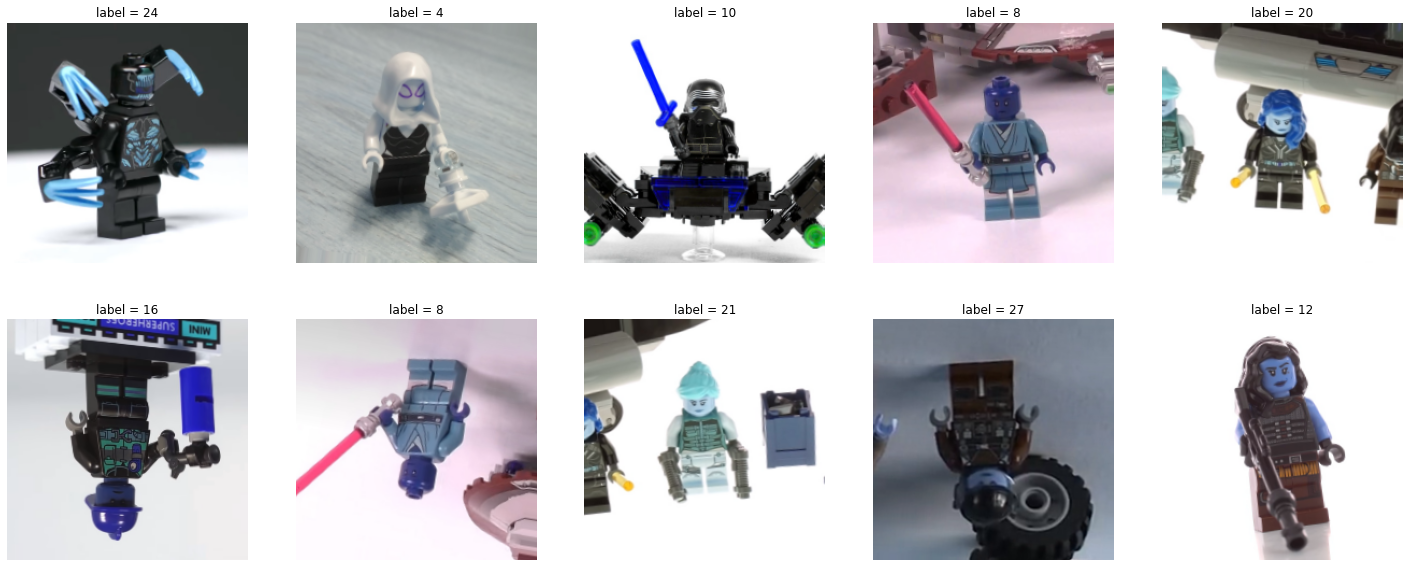

In [69]:
fig, axes = plt.subplots(2, 5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_training_images[i])
    ax.axis('off')
    ax.set_title("label = " + str(sample_training_labels[i].item()))

# Build the Model

In [91]:
# define the model
model =Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(30, activation='softmax')
])

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 64)      51264     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 49, 49, 128)       204928    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 256)      

# Train the Model

In [93]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
# train the model
history = model.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 512s 3s/step - loss: 3.3875 - accuracy: 0.0584 - val_loss: 3.4134 - val_accuracy: 0.0435
Epoch 2/100
200/200 [==============================] - 592s 3s/step - loss: 3.4159 - accuracy: 0.0410 - val_loss: 3.4207 - val_accuracy: 0.0362
Epoch 3/100
200/200 [==============================] - 513s 3s/step - loss: 3.4161 - accuracy: 0.0407 - val_loss: 3.4134 - val_accuracy: 0.0435
Epoch 4/100
200/200 [==============================] - 659s 3s/step - loss: 3.4154 - accuracy: 0.0415 - val_loss: 3.4134 - val_accuracy: 0.0435


# Plot Results

In [86]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

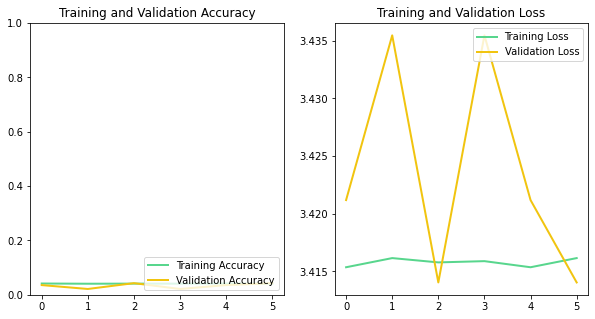

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

# Plot some example Predictions

In [88]:
sample_test_images, sample_test_labels = next(iter_valid)
predictions = model.predict(sample_test_images)

In [89]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Predicted cell type of the first image: 18.
True label: 9
--------------------
Predicted cell type of the first image: 18.
True label: 9
--------------------
Predicted cell type of the first image: 18.
True label: 13
--------------------
Predicted cell type of the first image: 18.
True label: 4
--------------------
Predicted cell type of the first image: 18.
True label: 16


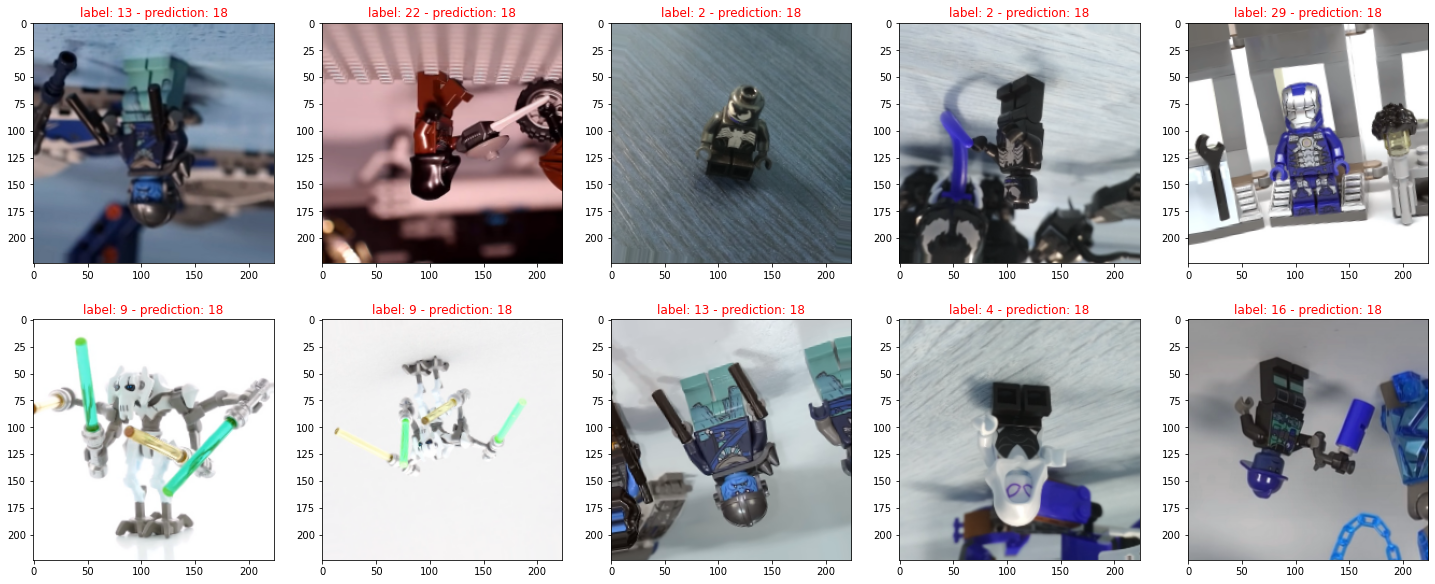

In [90]:
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))

# Try a second Model

In [98]:
# define the model
model1 =Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(30, activation='softmax') 
])

In [101]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [102]:
# train the model
history = model1.fit(
    iter_train,
    steps_per_epoch=200,#total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/100
200/200 [==============================] - 627s 3s/step - loss: 3.3865 - accuracy: 0.0607 - val_loss: 3.4061 - val_accuracy: 0.0507
Epoch 2/100
200/200 [==============================] - 371s 2s/step - loss: 3.3737 - accuracy: 0.0735 - val_loss: 3.3903 - val_accuracy: 0.0580
Epoch 3/100
200/200 [==============================] - 343s 2s/step - loss: 3.3675 - accuracy: 0.0788 - val_loss: 3.3799 - val_accuracy: 0.0507
Epoch 4/100
200/200 [==============================] - 335s 2s/step - loss: 3.3679 - accuracy: 0.0733 - val_loss: 3.3875 - val_accuracy: 0.0507
Epoch 5/100
200/200 [==============================] - 337s 2s/step - loss: 3.3678 - accuracy: 0.0788 - val_loss: 3.3997 - val_accuracy: 0.0362
Epoch 6/100
200/200 [==============================] - 329s 2s/step - loss: 3.3647 - accuracy: 0.0886 - val_loss: 3.4010 - val_accuracy: 0.0435


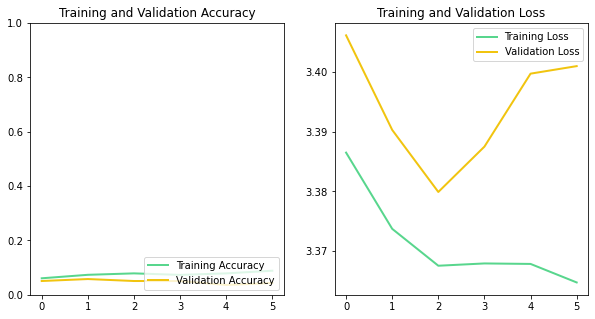

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

In [104]:
# some predictions
sample_test_images, sample_test_labels = next(iter_valid)
predictions = model.predict(sample_test_images)

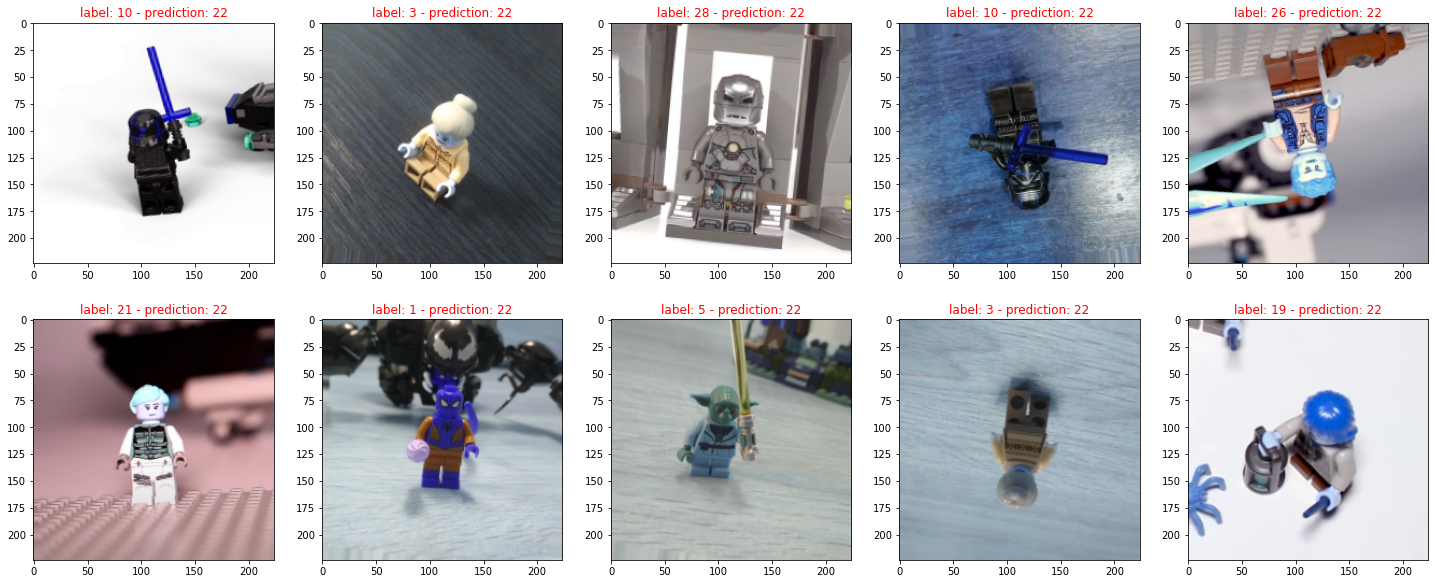

In [105]:
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))

# ToDo

* Hyperparameter Tuning
* Test Pretrained Model